## MNIST CNN

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

### Data

In [3]:
path = untar_data(URLs.MNIST)

In [4]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/training'),
 PosixPath('/root/.fastai/data/mnist_png/testing')]

In [5]:
il = ImageList.from_folder(path, convert_mode='L')

# black and white instead of RGB thats why the mode L

In [6]:
il.items[0] # itemlist contains the filenames

PosixPath('/root/.fastai/data/mnist_png/training/9/17107.png')

In [7]:
defaults.cmap='binary'
# default color map since we need black and white

In [8]:
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png

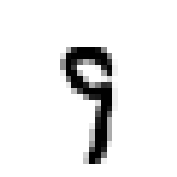

In [9]:
il[0].show()

In [10]:
sd = il.split_by_folder(train='training', valid='testing')
# splitting into training and validation
# we use no_split to say  no validation required

In [11]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Test: None

In [12]:
(path/'training').ls()

[PosixPath('/root/.fastai/data/mnist_png/training/9'),
 PosixPath('/root/.fastai/data/mnist_png/training/7'),
 PosixPath('/root/.fastai/data/mnist_png/training/8'),
 PosixPath('/root/.fastai/data/mnist_png/training/0'),
 PosixPath('/root/.fastai/data/mnist_png/training/2'),
 PosixPath('/root/.fastai/data/mnist_png/training/1'),
 PosixPath('/root/.fastai/data/mnist_png/training/4'),
 PosixPath('/root/.fastai/data/mnist_png/training/6'),
 PosixPath('/root/.fastai/data/mnist_png/training/5'),
 PosixPath('/root/.fastai/data/mnist_png/training/3')]

In [13]:
ll = sd.label_from_folder()

In [14]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
9,9,9,9,9
Path: /root/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
9,9,9,9,9
Path: /root/.fastai/data/mnist_png;

Test: None

In [15]:
x,y = ll.train[0]

# calling this will get you two independent variables x and y
# x will be an image object and y will be label

9 torch.Size([1, 28, 28])


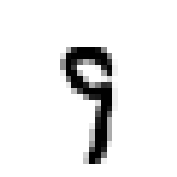

In [16]:
x.show()
print(y,x.shape)

In [17]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

# we won't be using usual transformation og glipping etc since th emeaning changes.
# we just add random padding
# empty array signifies that no transform on validation dataset


In [18]:
ll = ll.transform(tfms)

In [19]:
bs = 128

In [20]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()
# if we pass data like this it will automatically grab a random data

In [21]:
x,y = data.train_ds[0]

9


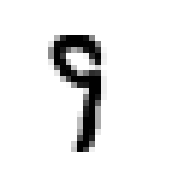

In [22]:
x.show()
print(y)

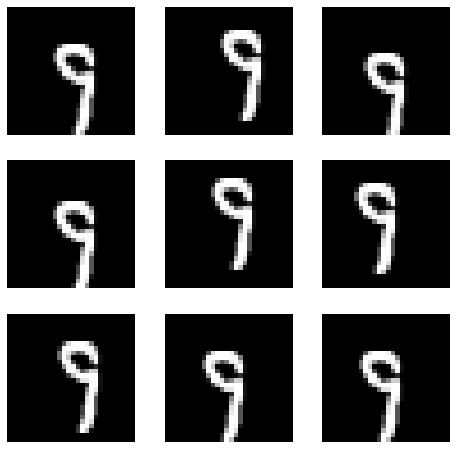

In [23]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

# plot multi is a fast ai based set that can be used to plot multiple images
# it shows that each time we grab a dataset from the training set
# it is transformed on the fly 

In [24]:
xb,yb = data.one_batch()
xb.shape,yb.shape
# we can load an entire batch here

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

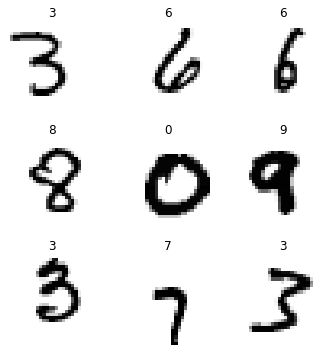

In [25]:
data.show_batch(rows=3, figsize=(5,5))

### Basic CNN with batchnorm

In [26]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)


In [27]:
model = nn.Sequential(
    conv(1, 8), # 14 # we get to pick number of filters
    # it is 8 by 14 by 14 activations
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7 # 7 is the grid size
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [28]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [29]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [30]:
xb = xb.cuda()

In [31]:
model(xb).shape

torch.Size([128, 10])

In [32]:
learn.lr_find(end_lr=100)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


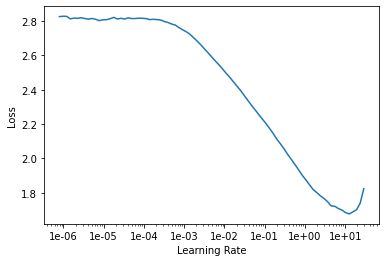

In [33]:
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.215360,0.294437,0.908500,00:25
1,0.128761,0.085971,0.972300,00:25
2,0.064395,0.039777,0.988100,00:25


### Refactor

In [35]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [36]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [37]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [38]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.237004,0.142904,0.957600,00:25
1,0.179737,0.133961,0.957100,00:25
2,0.156121,0.217058,0.929200,00:25
3,0.149778,0.086703,0.972100,00:25
4,0.125351,0.100675,0.967700,00:25
5,0.107327,0.072937,0.978300,00:25
6,0.083284,0.056571,0.983000,00:25
7,0.070423,0.039749,0.987800,00:25
8,0.052524,0.033465,0.989300,00:25
9,0.042632,0.030099,0.990200,00:25


### Resnet-ish

In [39]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [40]:
help(res_block) # there is  resblock already in fast ai

Help on function res_block in module fastai.layers:

res_block(nf, dense:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, bottle:bool=False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [41]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32), # resblock can be added in multiple research paper
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [42]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [43]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [44]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


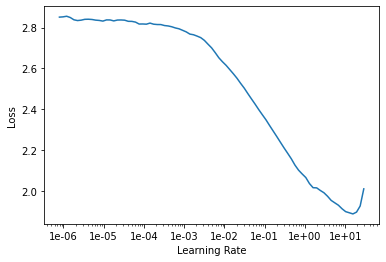

In [45]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [46]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.210195,0.120630,0.963200,00:28
1,0.129546,0.130457,0.958700,00:28
2,0.100447,0.111855,0.963900,00:28
3,0.082784,0.069076,0.978600,00:28
4,0.075367,0.176353,0.946900,00:28
5,0.063835,0.046560,0.984300,00:28
6,0.053958,0.033842,0.989600,00:28
7,0.038644,0.041978,0.988000,00:28
8,0.035796,0.024208,0.992000,00:28
9,0.027377,0.016154,0.995200,00:28


In [47]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
___________________________________________________

## fin